In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import seaborn as sns
from scipy.stats import norm, pearsonr, spearmanr
import scipy.stats as stats
from scipy.spatial import distance
from sklearn.feature_selection import VarianceThreshold
import cloudpickle as pickle
import warnings
warnings.filterwarnings("ignore")
mpl.rcParams['pdf.fonttype'] = 42 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [2]:
def get_matched_pair_set(pairs):
    pair_set = []
    for i in pairs.index:
        for j in pairs.loc[i, :]:
            pair_set.append([i, j])
    pair_set = pd.DataFrame(pair_set, columns=['Case', 'Control'])
    pair_set = pair_set.dropna(how='any')
    return pair_set

def load_resdata(project, path='../Temp/'):
    ### matched result
    matched = pd.read_csv(path+project+'/PSM_Matched.tsv', index_col=0, sep='\t')
    taxa_diff = pd.read_csv(path+project+'/Microbiome_difference.csv', index_col=0).fillna(0)
    path_diff = pd.read_csv(path+project+'/Pathway_difference.csv', index_col=0).fillna(0)
    pairs = pd.read_csv(path+project+'/PSM_Matched_Pairs.tsv', index_col=0, sep='\t')
    pair_set = get_matched_pair_set(pairs)
    ### Raw data
    metadata = pd.read_csv(path+project+'/Metadata.csv', index_col=0)
    microbiome = pd.read_csv(path+project+'/Microbiome.csv', index_col=0)
    pathway = pd.read_csv(path+project+'/Pathway.csv', index_col=0)
    return metadata, matched, taxa_diff, path_diff, pair_set, microbiome, pathway

In [14]:
path = '../Temp/'
projects = [i for i in os.listdir(path) if '.csv' not in i and '.ipynb_checkpoints' not in i and '.DS_Store' not in i and '.RData' not in i and '.Rhistory' not in i]
len(projects), projects[:5]
#projects.remove('29')
#len(projects)

(88, ['08', '09', '100', '101', '11'])

In [15]:
projects_message=pd.read_csv('../Label/fenzu.csv',index_col=0).T
projects_message=projects_message.to_dict('list')
projects_message

{'01': ['AsnicarF_2017', 'milk', 'control', nan],
 '02': ['AsnicarF_2017', 'stool', 'control', nan],
 '03': ['AsnicarF_2021', 'stool', 'control', nan],
 '04': ['BackhedF_2015', 'stool', 'control', nan],
 '05': ['Bengtsson-PalmeJ_2015', 'stool', 'control', nan],
 '06': ['BritoIL_2016', 'oralcavity', 'control', nan],
 '07': ['BritoIL_2016', 'stool', 'control', nan],
 '08': ['BrooksB_2017', 'stool', 'control', 'premature_born'],
 '09': ['Castro-NallarE_2015', 'oralcavity', 'control', 'schizofrenia'],
 '10': ['ChengpingW_2017', 'stool', 'AS', nan],
 '11': ['ChngKR_2016', 'skin', 'control', 'AD'],
 '12': ['ChuDM_2017', 'oralcavity', 'control', nan],
 '13': ['ChuDM_2017', 'stool', 'control', nan],
 '14': ['CosteaPI_2017', 'stool', 'control', nan],
 '15': ['DavidLA_2015', 'stool', 'control', 'acute_diarrhoea'],
 '16': ['DeFilippisF_2019', 'stool', 'control', nan],
 '17': ['DhakanDB_2019', 'stool', 'control', nan],
 '18_1': ['FengQ_2015', 'stool', 'control', 'adenoma'],
 '18_2': ['FengQ_2015',

In [4]:
P_VALUE_THRESHOLLD = 0.05
FDR_VALUE_THRESHOLLD = 0.05
COHEN_THRESHOLLD = 0.5

In [18]:
result = []
for project in projects:
    metadata, matched, taxa_diff, path_diff, pairs, microbiome, pathway = load_resdata(project)
    #path_diff
    project
    row = []
    ### pvalue
    path_raw_sig = path_diff.loc[path_diff['p-value(raw)']<P_VALUE_THRESHOLLD, :]
    path_psm_sig = path_diff.loc[path_diff['p-value(PSM)']<P_VALUE_THRESHOLLD, :]
    row.extend([project, path_raw_sig.shape[0], path_psm_sig.shape[0], len(set(path_raw_sig.index)&set(path_psm_sig.index))])
    ### fdr
    path_raw_sig = path_diff.loc[path_diff['fdr(raw)']<FDR_VALUE_THRESHOLLD, :]
    path_psm_sig = path_diff.loc[path_diff['fdr(PSM)']<FDR_VALUE_THRESHOLLD, :]
    row.extend([path_raw_sig.shape[0], path_psm_sig.shape[0], len(set(path_raw_sig.index)&set(path_psm_sig.index))])
    ### d>0.2
    path_raw_sig = path_diff.loc[path_diff["cohen's d(raw)"]>0.2, :]
    path_psm_sig = path_diff.loc[path_diff["cohen's d(PSM)"]>0.2, :]
    row.extend([path_raw_sig.shape[0], path_psm_sig.shape[0], len(set(path_raw_sig.index)&set(path_psm_sig.index))])
    ### d>0.5
    path_raw_sig = path_diff.loc[path_diff["cohen's d(raw)"]>0.5, :]
    path_psm_sig = path_diff.loc[path_diff["cohen's d(PSM)"]>0.5, :]
    row.extend([path_raw_sig.shape[0], path_psm_sig.shape[0], len(set(path_raw_sig.index)&set(path_psm_sig.index))])
    result.append(row)
result = pd.DataFrame(result, columns=['Project', 'Unmatched_p<0.05', 'Matched_p<0.05', 'Overlap_p<0.05', 
                                       'Unmatched_fdr<0.05', 'Matched_fdr<0.05', 'Overlap_fdr<0.05', 
                                       "Unmatched_cohen's d>0.2", "Matched_cohen's d>0.2", "Overlap_cohen's d>0.2", 
                                       "Unmatched_cohen's d>0.5", "Matched_cohen's d>0.5", "Overlap_cohen's d>0.5"])
result

'08'

'09'

'100'

'101'

'11'

'15'

'18_1'

'18_2'

'18_3'

'24_1'

'24_2'

'24_3'

'26'

'27'

'28_1'

'28_2'

'28_3'

'30'

'36'

'37_1'

'37_2'

'37_3'

'38'

'39'

'40_1'

'40_2'

'40_3'

'43'

'44'

'48_1'

'48_2'

'48_3'

'48_4'

'48_5'

'48_6'

'49_1'

'49_2'

'49_3'

'50_1'

'50_2'

'50_3'

'54_1'

'54_2'

'54_3'

'58'

'59'

'68'

'69'

'71'

'72'

'73'

'74'

'76'

'78'

'81_1'

'81_2'

'81_3'

'82'

'83'

'84_1'

'84_10'

'84_11'

'84_14'

'84_15'

'84_17'

'84_2'

'84_4'

'84_5'

'84_7'

'84_8'

'84_9'

'86'

'87'

'91'

'92_1'

'92_2'

'92_3'

'93_1'

'93_2'

'93_3'

'93_4'

'93_5'

'93_6'

'96'

'97'

'99_1'

'99_2'

'99_3'

Project  Unmatched_p<0.05  Matched_p<0.05  Overlap_p<0.05  \
0       08               211             396             198   
1       09               125             117              40   
2      100                55             105              48   
3      101                63             103              32   
4       11               248             190             131   
..     ...               ...             ...             ...   
83      96                43              33              12   
84      97                30             159              29   
85    99_1                64             128              41   
86    99_2               141              63              40   
87    99_3               165              91              42   

    Unmatched_fdr<0.05  Matched_fdr<0.05  Overlap_fdr<0.05  \
0                  123               392               115   
1                   30                74                16   
2                    0                42                 0   
3                    2                49                 2   
4                  184               150                61   
..                 ...               ...               ...   
83                   0                 0                 0   
84                   2                88                 2   
85                   0                53                 0   
86                  41                 5                 5   
87                  85                37                12   

    Unmatched_cohen's d>0.2  Matched_cohen's d>0.2  Overlap_cohen's d>0.2  \
0                       397                    395                    369   
1                       428                    375                    341   
2                       138                    144                     71   
3                       233                    147                     91   
4                       379                    211                    179   
..                      ...                    ...                    ...   
83                      198                    180                    102   
84                      133                    143                     73   
85                      234                    202                    122   
86                      317                    223                    156   
87                      329                    195                    123   

    Unmatched_cohen's d>0.5  Matched_cohen's d>0.5  Overlap_cohen's d>0.5  
0                       283                    315                    237  
1                       314                    168                     98  
2                         8                      9                      6  
3                        19                     10                      6  
4                       226                     24                     21  
..                      ...                    ...                    ...  
83                       64                     23                     16  
84                        3                      7                      3  
85                       17                     13                      6  
86                       54                     33                     16  
87                       98                     15                      6  

[88 rows x 13 columns]

In [19]:
result.to_csv('../ShowFigures_Results/Table S3Add. Differential pathway.csv')

0.4588911396663411

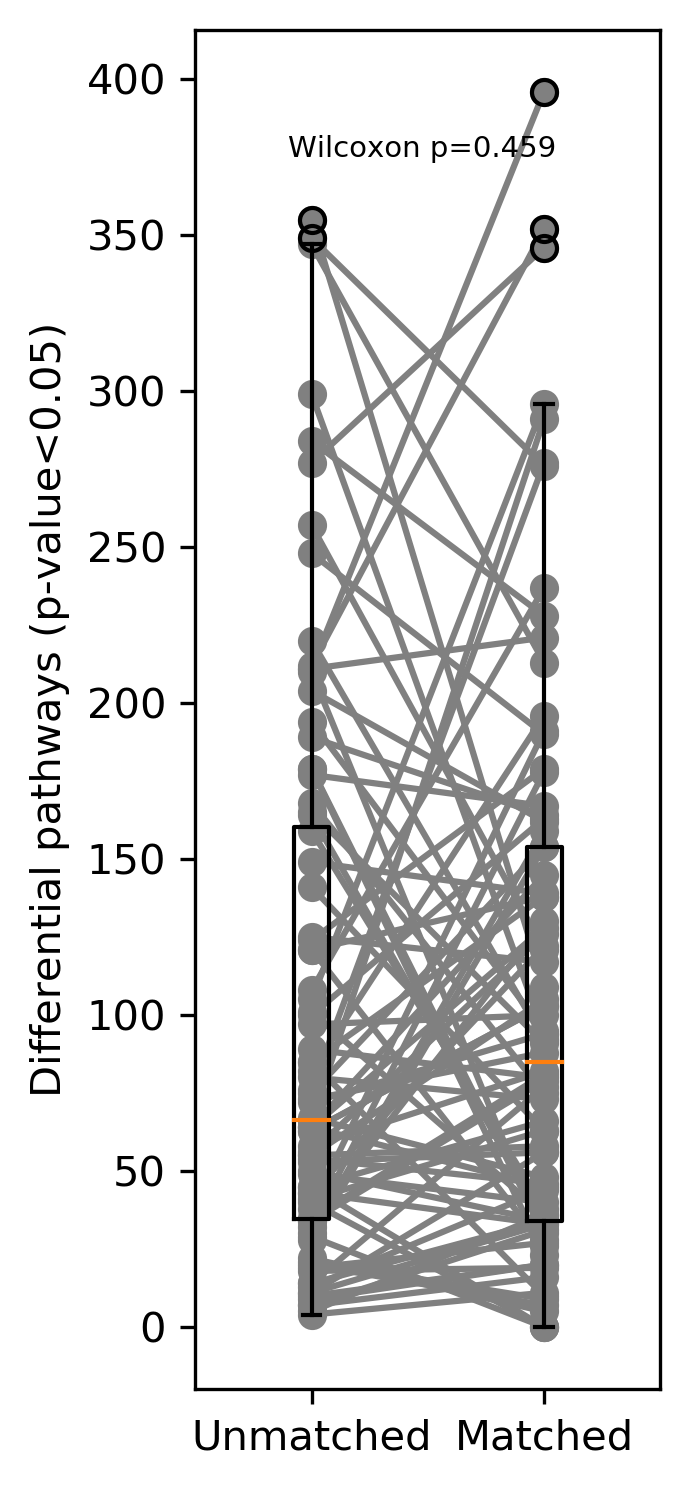

In [6]:
result = []
for project in projects:
    metadata, matched, taxa_diff, path_diff, pairs, microbiome, pathway = load_resdata(project)
    path_raw_sig = path_diff.loc[path_diff['p-value(raw)']<P_VALUE_THRESHOLLD, :]
    path_psm_sig = path_diff.loc[path_diff['p-value(PSM)']<P_VALUE_THRESHOLLD, :]
    #taxa_raw_sig.shape[0], taxa_psm_sig.shape[0], len(set(taxa_raw_sig.index)&set(taxa_psm_sig.index))
    result.append([project, path_raw_sig.shape[0], path_psm_sig.shape[0], len(set(path_raw_sig.index)&set(path_psm_sig.index))])
result = pd.DataFrame(result, columns=['Project', 'Diff_unmatched', 'Diff_matched', 'Overlap'])
#result
stats.wilcoxon(result['Diff_unmatched'], result['Diff_matched'])[1]

_ = plt.figure(0, (2, 6), dpi=300)
for i in result.index:
    _ = plt.plot([1, 2], result.loc[i, ['Diff_unmatched', 'Diff_matched']], '-o', alpha=1, color='gray')
_ = plt.boxplot([result['Diff_unmatched'], result['Diff_matched']])
_ = plt.annotate('Wilcoxon p=0.459', (0.9, 375), fontsize=7)
_ = plt.ylabel('Differential pathways (p-value<0.05)')
_ = plt.xticks([1, 2], ['Unmatched', 'Matched'])
#plt.savefig('../Results/4.通路变化pvalue.pdf',bbox_inches = 'tight')
_ = plt.show()

0.4928494818065259

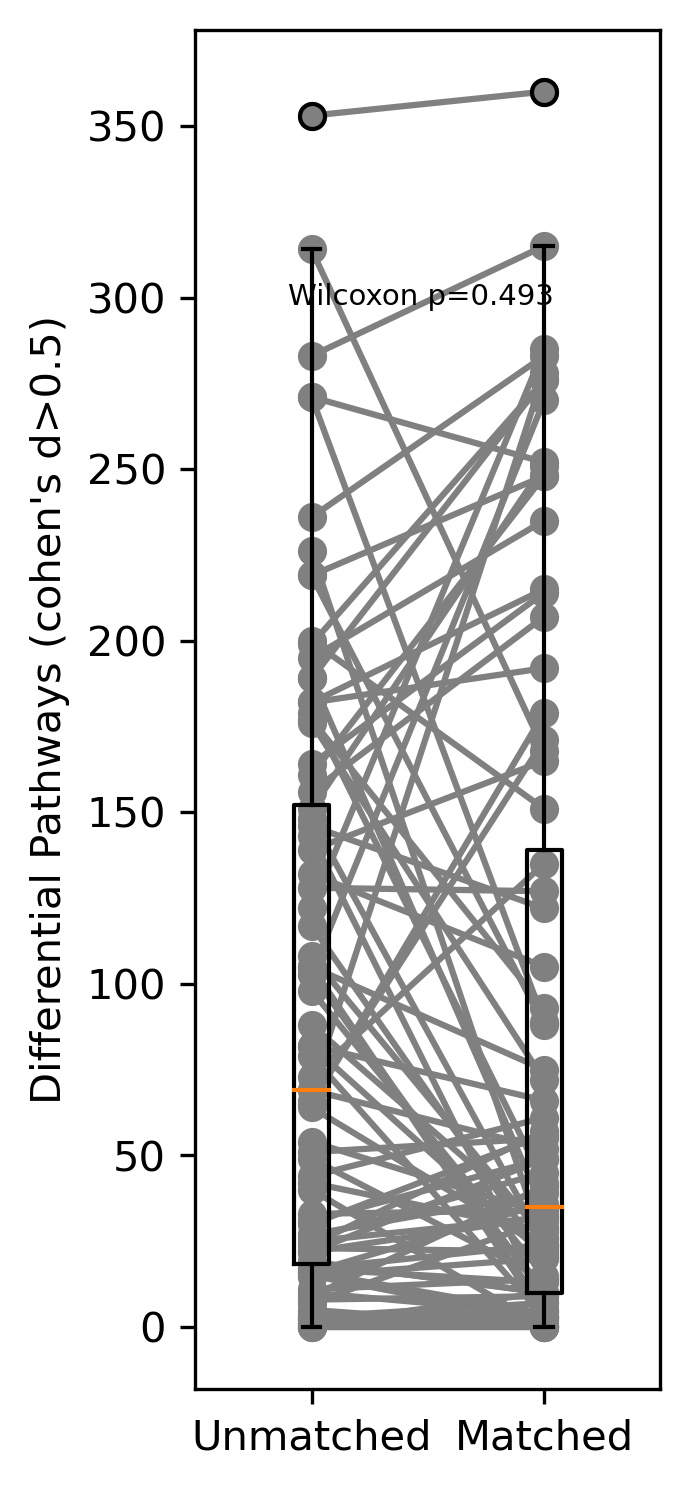

In [6]:
result = []
for project in projects:
    metadata, matched, taxa_diff, path_diff, pairs, microbiome, pathway = load_resdata(project)
    path_raw_sig = path_diff.loc[path_diff["cohen's d(raw)"]>COHEN_THRESHOLLD, :]
    path_psm_sig = path_diff.loc[path_diff["cohen's d(PSM)"]>COHEN_THRESHOLLD, :]
    #taxa_raw_sig.shape[0], taxa_psm_sig.shape[0], len(set(taxa_raw_sig.index)&set(taxa_psm_sig.index))
    result.append([project, path_raw_sig.shape[0], path_psm_sig.shape[0], len(set(path_raw_sig.index)&set(path_psm_sig.index))])
result = pd.DataFrame(result, columns=['Project', 'Diff_unmatched', 'Diff_matched', 'Overlap'])
#result
stats.wilcoxon(result['Diff_unmatched'], result['Diff_matched'])[1]

_ = plt.figure(0, (2, 6), dpi=300)
for i in result.index:
    _ = plt.plot([1, 2], result.loc[i, ['Diff_unmatched', 'Diff_matched']], '-o', alpha=1, color='gray')
_ = plt.boxplot([result['Diff_unmatched'], result['Diff_matched']])
_ = plt.annotate('Wilcoxon p=0.493', (0.9, 298), fontsize=7)
_ = plt.ylabel("Differential Pathways (cohen's d>0.5)")
_ = plt.xticks([1, 2], ['Unmatched', 'Matched'])
#plt.savefig('../Results/4.通路变化cohen.pdf',bbox_inches = 'tight')
_ = plt.show()

# 4. Pathway change
### 4.1 Effect size

In [7]:
delta_ds = pd.DataFrame()
for project in projects:
    metadata, matched, taxa_diff, path_diff, pairs, microbiome, pathway = load_resdata(project)
    delta_ds[project] = path_diff["cohen's d(PSM)"]-path_diff["cohen's d(raw)"]

In [8]:
result = []
for path in delta_ds.index:
    for study in delta_ds.columns:
        path_class = path
        result.append([path, path_class, study, delta_ds.loc[path, study]])
result = pd.DataFrame(result, columns=['path', 'Class', 'Study', 'Delta_D'])

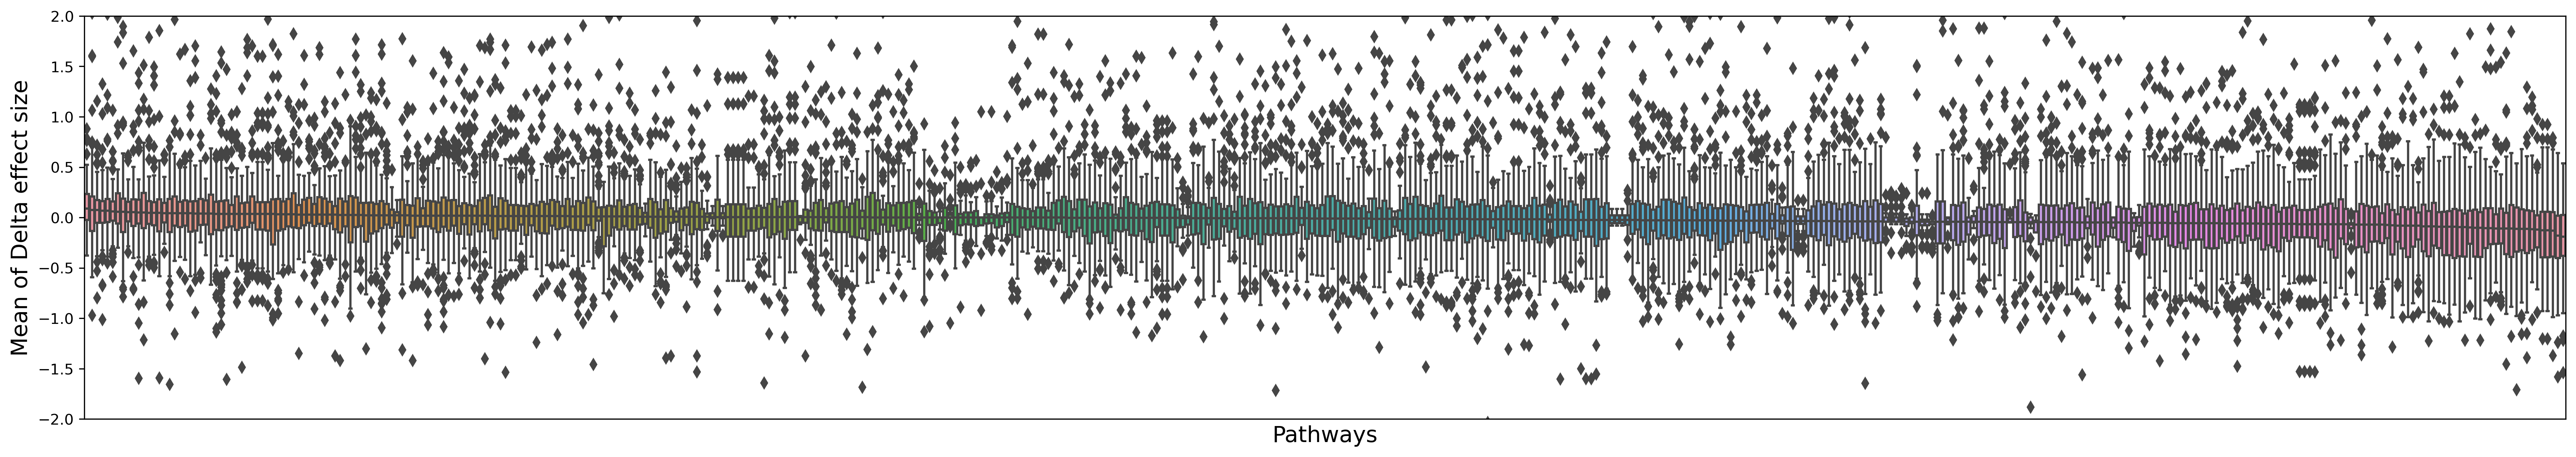

In [9]:
order = result.groupby('Class').median().sort_values('Delta_D', ascending=False).index
_ = plt.figure(0, (30, 5), dpi=300)
_ = sns.boxplot(x="Class", y="Delta_D", data=result, order=order)
#_ = plt.xticks(rotation=45, ha='right')
_ = plt.xticks([], [])
_ = plt.ylim(-2,2)
_ = plt.ylabel('Mean of Delta effect size', fontsize=15)
_ = plt.xlabel('Pathways', fontsize=15)
#plt.savefig('../Results/4.MeanDeltaEffectSize.pdf',bbox_inches = 'tight')
_ = plt.show()

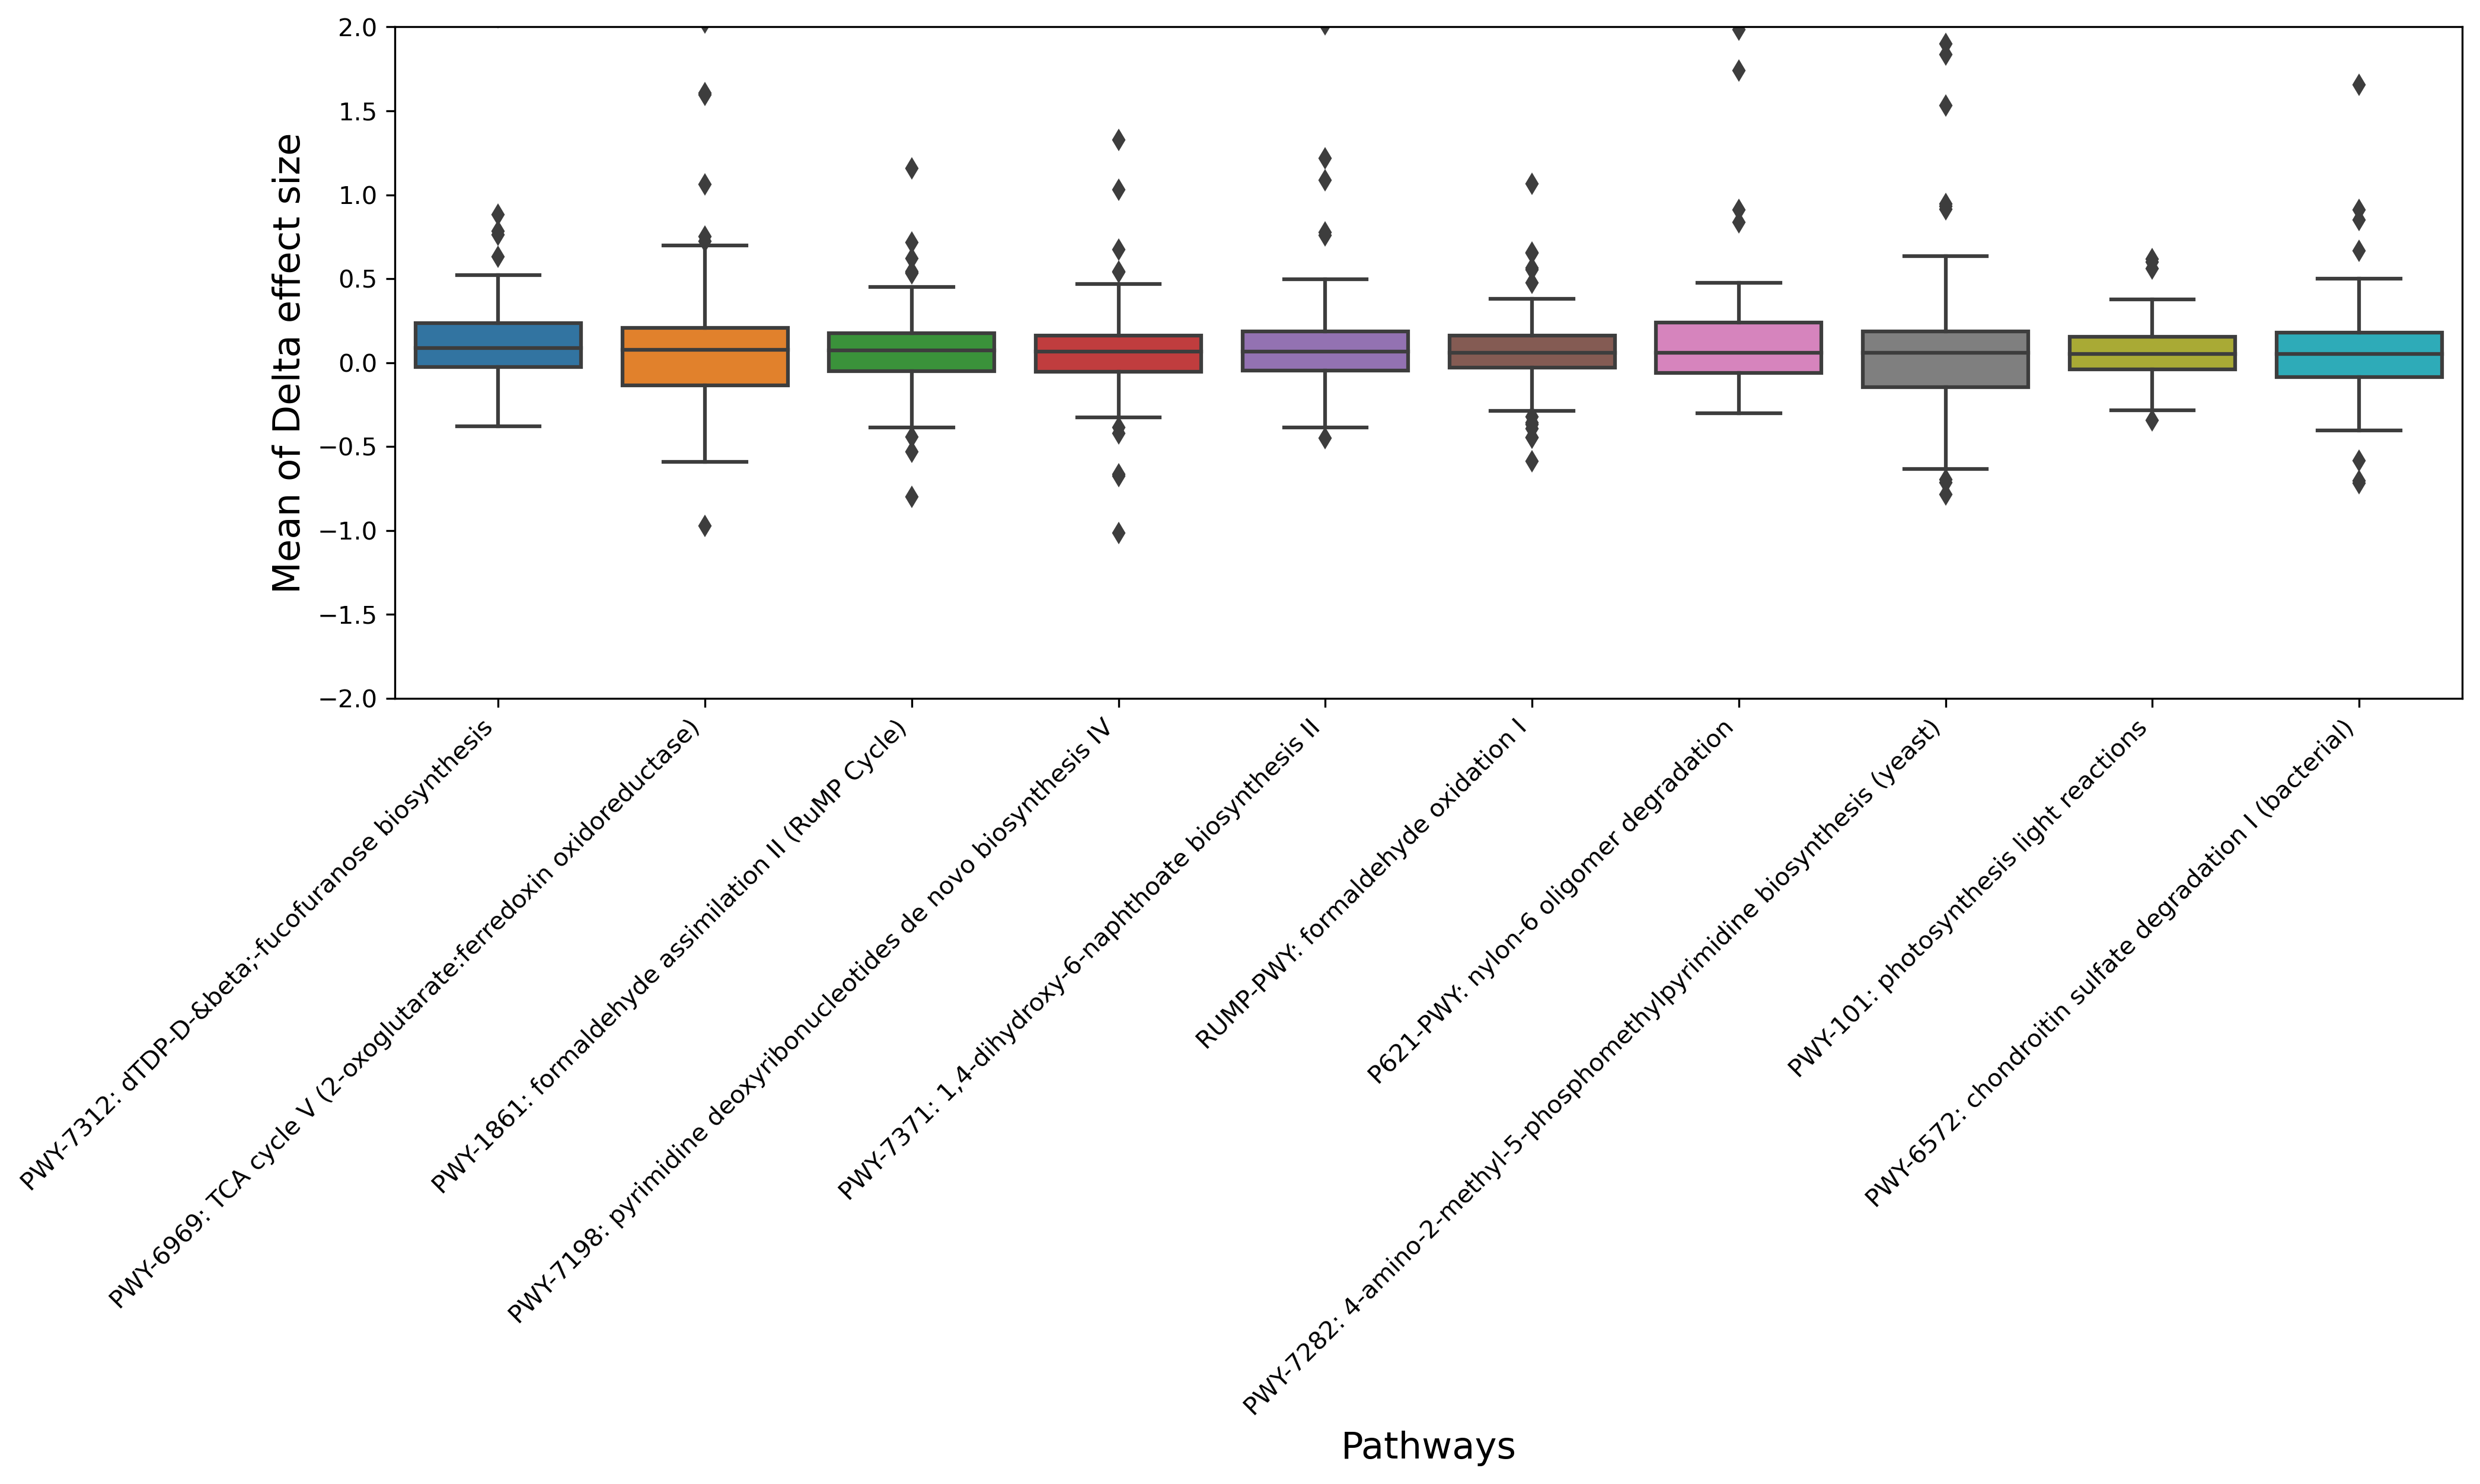

In [10]:
medians = result.groupby('Class').median().sort_values(['Delta_D'], ascending=False)
order = medians.index[:10]

_ = plt.figure(0, (15, 5), dpi=300)
_ = sns.boxplot(x="Class", y="Delta_D", data=result, order=order)
_ = plt.xticks(rotation=45, ha='right')
#_ = plt.xticks([], [])
_ = plt.ylim(-2,2)
_ = plt.ylabel('Mean of Delta effect size', fontsize=15)
_ = plt.xlabel('Pathways', fontsize=15)
#plt.savefig('../Results/4.MeanDeltaEffectSize_top10.pdf',bbox_inches = 'tight')
_ = plt.show()

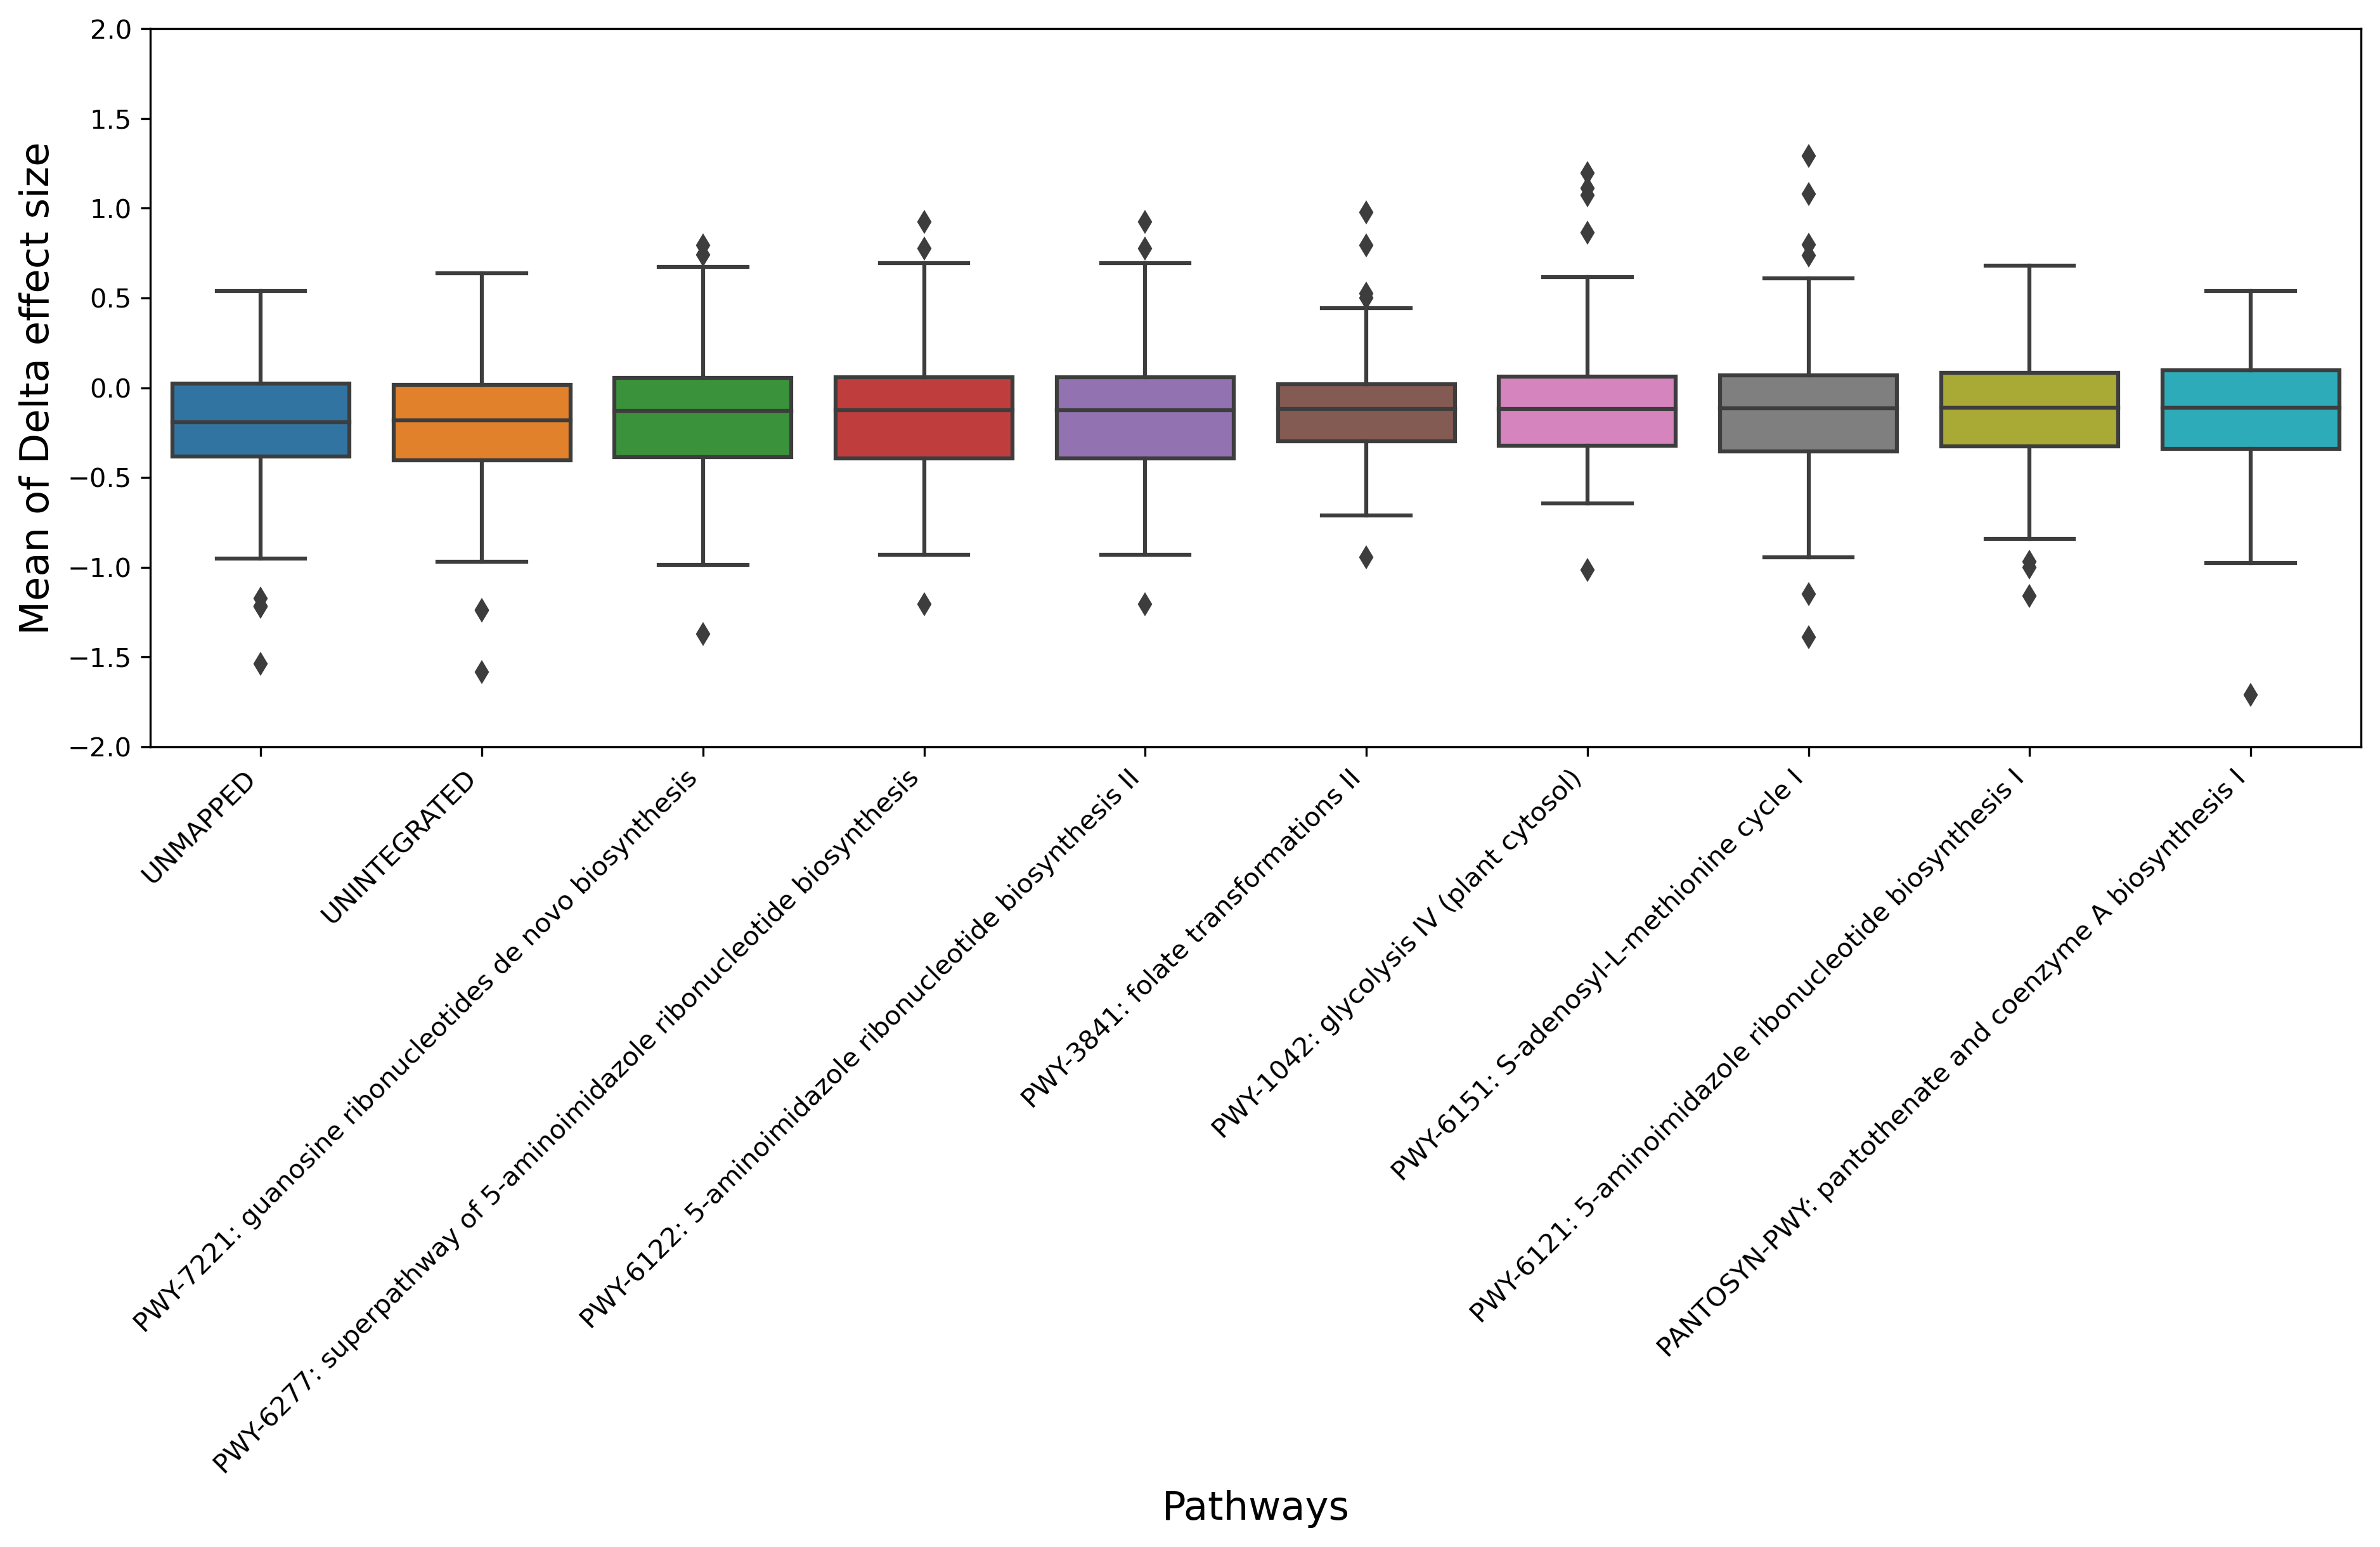

In [11]:
medians = result.groupby('Class').median().sort_values(['Delta_D'], ascending=True)
order = medians.index[:10]

_ = plt.figure(0, (15, 5), dpi=300)
_ = sns.boxplot(x="Class", y="Delta_D", data=result, order=order)
_ = plt.xticks(rotation=45, ha='right')
#_ = plt.xticks([], [])
_ = plt.ylim(-2,2)
_ = plt.ylabel('Mean of Delta effect size', fontsize=15)
_ = plt.xlabel('Pathways', fontsize=15)
#plt.savefig('../Results/4.MeanDeltaEffectSize_End10.pdf',bbox_inches = 'tight')
_ = plt.show()

### 4.2 P-value

In [12]:
logp_ds = pd.DataFrame()
for project in projects:
    metadata, matched, taxa_diff, path_diff, pairs, microbiome, pathway = load_resdata(project)
    logp_ds[project] = np.log10(path_diff["p-value(raw)"])-np.log(path_diff["p-value(PSM)"])
    
result = []
for path in logp_ds.index:
    for study in logp_ds.columns:
        path_class = path
        result.append([path, path_class, study, logp_ds.loc[path, study]])
result = pd.DataFrame(result, columns=['path', 'Class', 'Study', 'Delta_logp'])
result.head()
#result.to_csv('../Results/4.pathway_Delta.csv')

path  \
0  PWY-7383: anaerobic energy metabolism (inverte...   
1  PWY-7383: anaerobic energy metabolism (inverte...   
2  PWY-7383: anaerobic energy metabolism (inverte...   
3  PWY-7383: anaerobic energy metabolism (inverte...   
4  PWY-7383: anaerobic energy metabolism (inverte...   

                                               Class Study  Delta_logp  
0  PWY-7383: anaerobic energy metabolism (inverte...    08  135.424123  
1  PWY-7383: anaerobic energy metabolism (inverte...    09   -1.781034  
2  PWY-7383: anaerobic energy metabolism (inverte...   100    3.284960  
3  PWY-7383: anaerobic energy metabolism (inverte...   101    4.462472  
4  PWY-7383: anaerobic energy metabolism (inverte...    11    0.066967

In [13]:
result=pd.read_csv('../Results/4.pathway_Delta.csv')

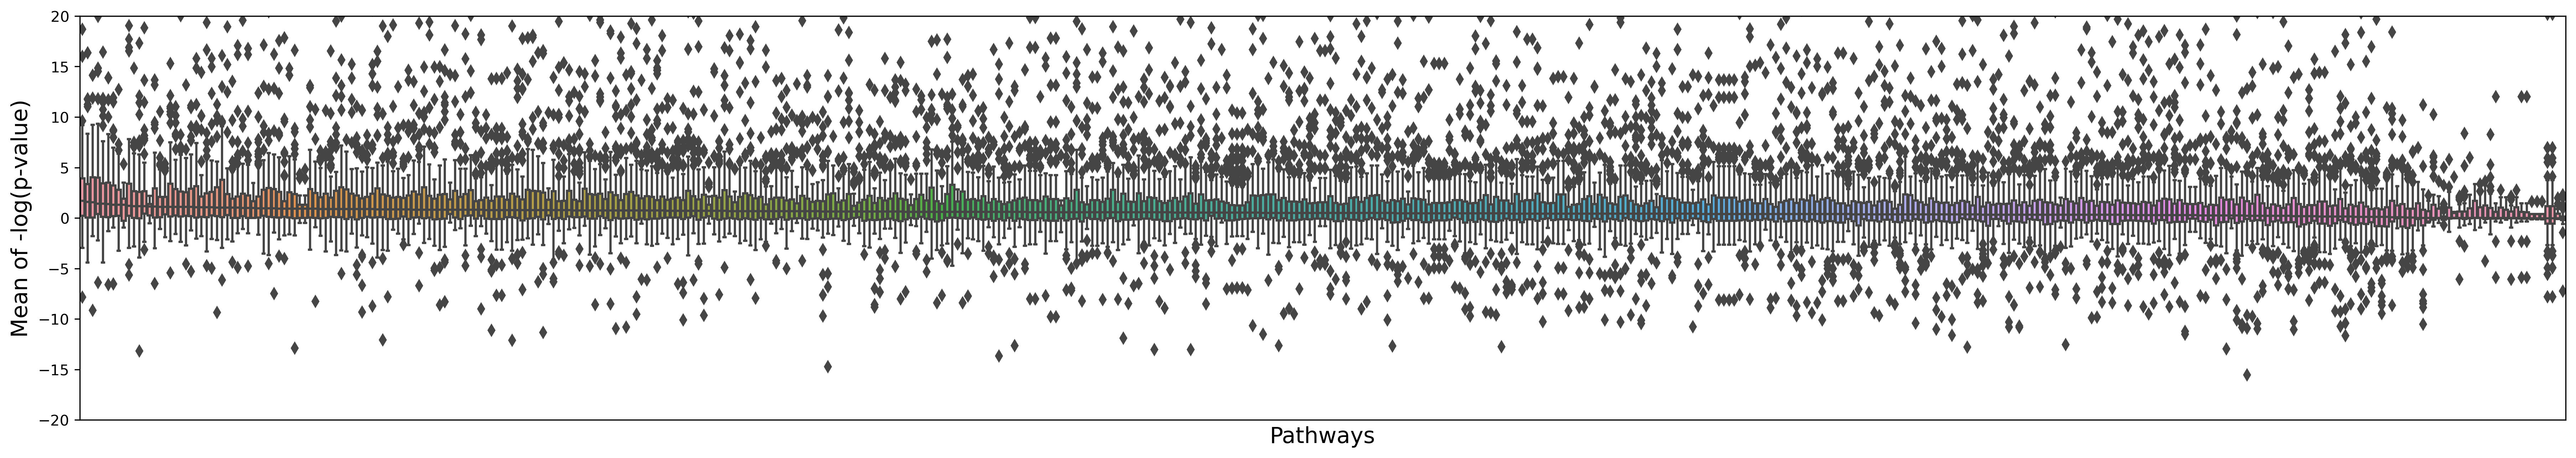

In [14]:
order = result.groupby('Class').median().sort_values('Delta_logp', ascending=False).index
_ = plt.figure(0, (30, 5), dpi=300)
_ = sns.boxplot(x="Class", y="Delta_logp", data=result, order=order)
#_ = plt.xticks(rotation=45, ha='right')
_ = plt.xticks([], [])
_ = plt.ylim(-20,20)
_ = plt.ylabel('Mean of -log(p-value)', fontsize=15)
_ = plt.xlabel('Pathways', fontsize=15)
#plt.savefig('../Results/4.PathwayDelta_logp.pdf',bbox_inches = 'tight')
_ = plt.show()

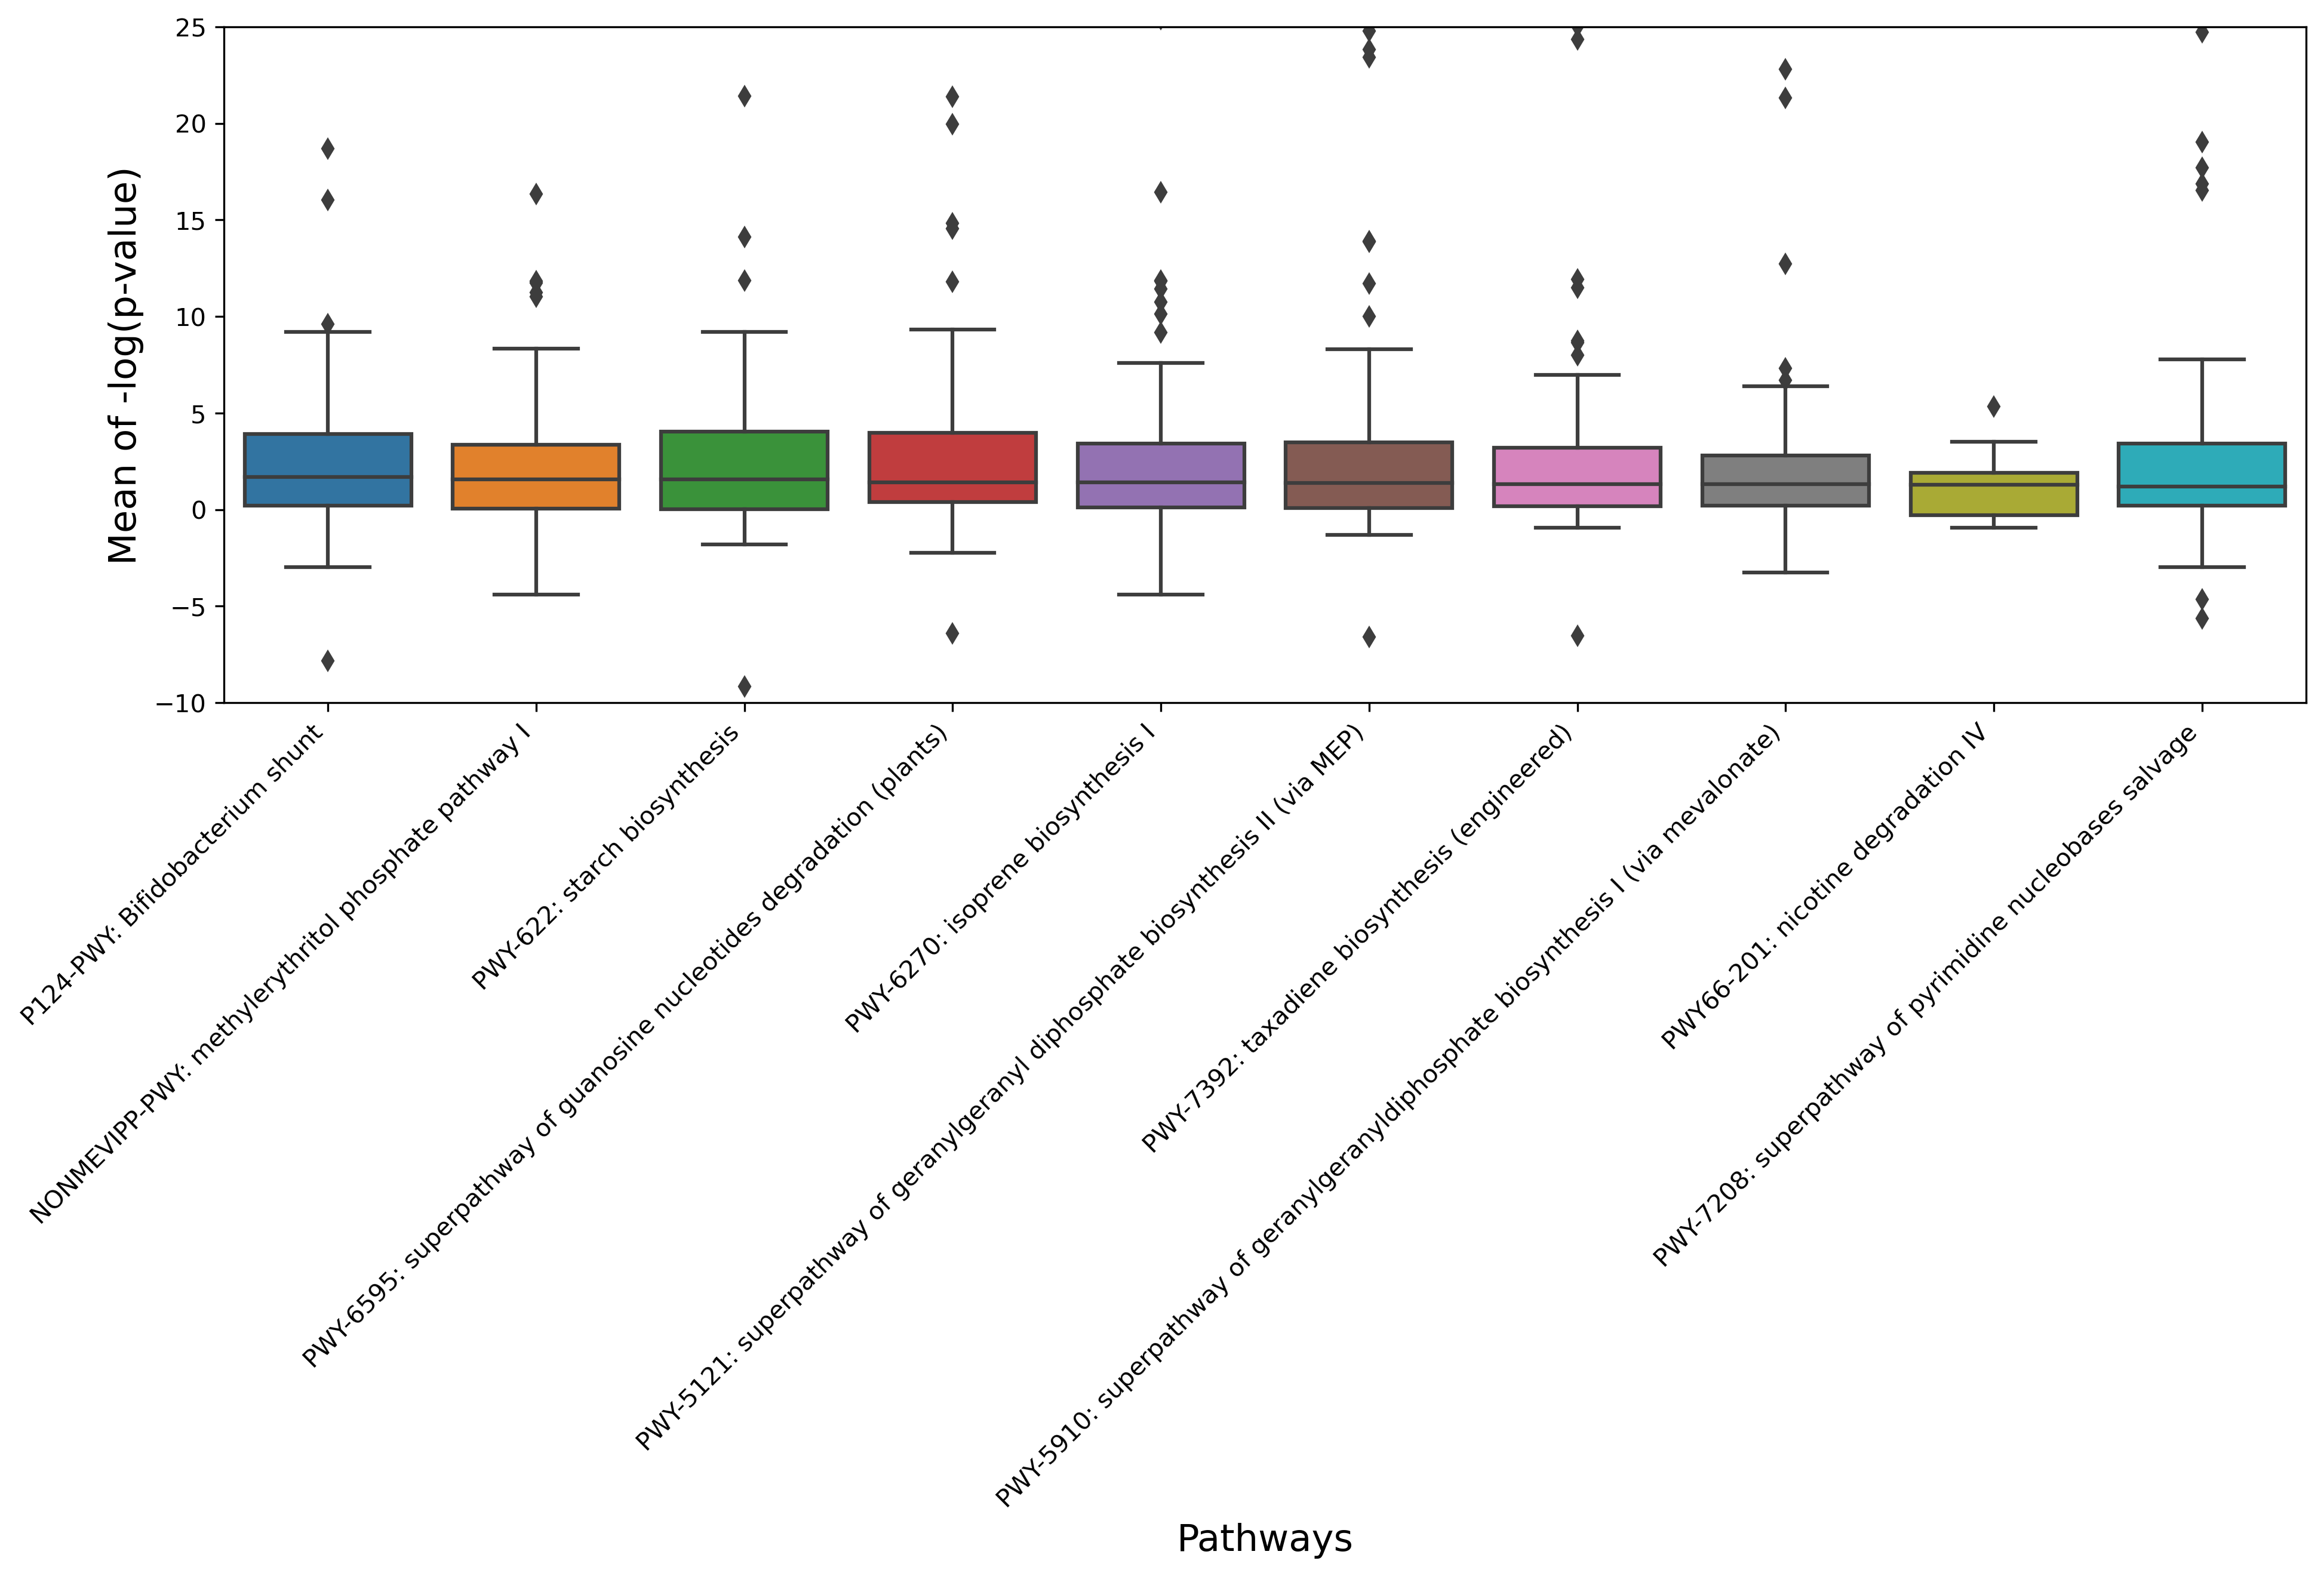

In [16]:
medians = result.groupby('Class').median().sort_values(['Delta_logp'], ascending=False)
order = medians.index[:10]
_ = plt.figure(0, (15, 5), dpi=300)
_ = sns.boxplot(x="Class", y="Delta_logp", data=result, order=order)
_ = plt.xticks(rotation=45, ha='right')
#_ = plt.xticks([], [])
_ = plt.ylim(-10,25)
_ = plt.ylabel('Mean of -log(p-value)', fontsize=15)
_ = plt.xlabel('Pathways', fontsize=15)
#plt.savefig('../Results/4.PathwayDelta_logp_top10.pdf',bbox_inches = 'tight')
_ = plt.show()

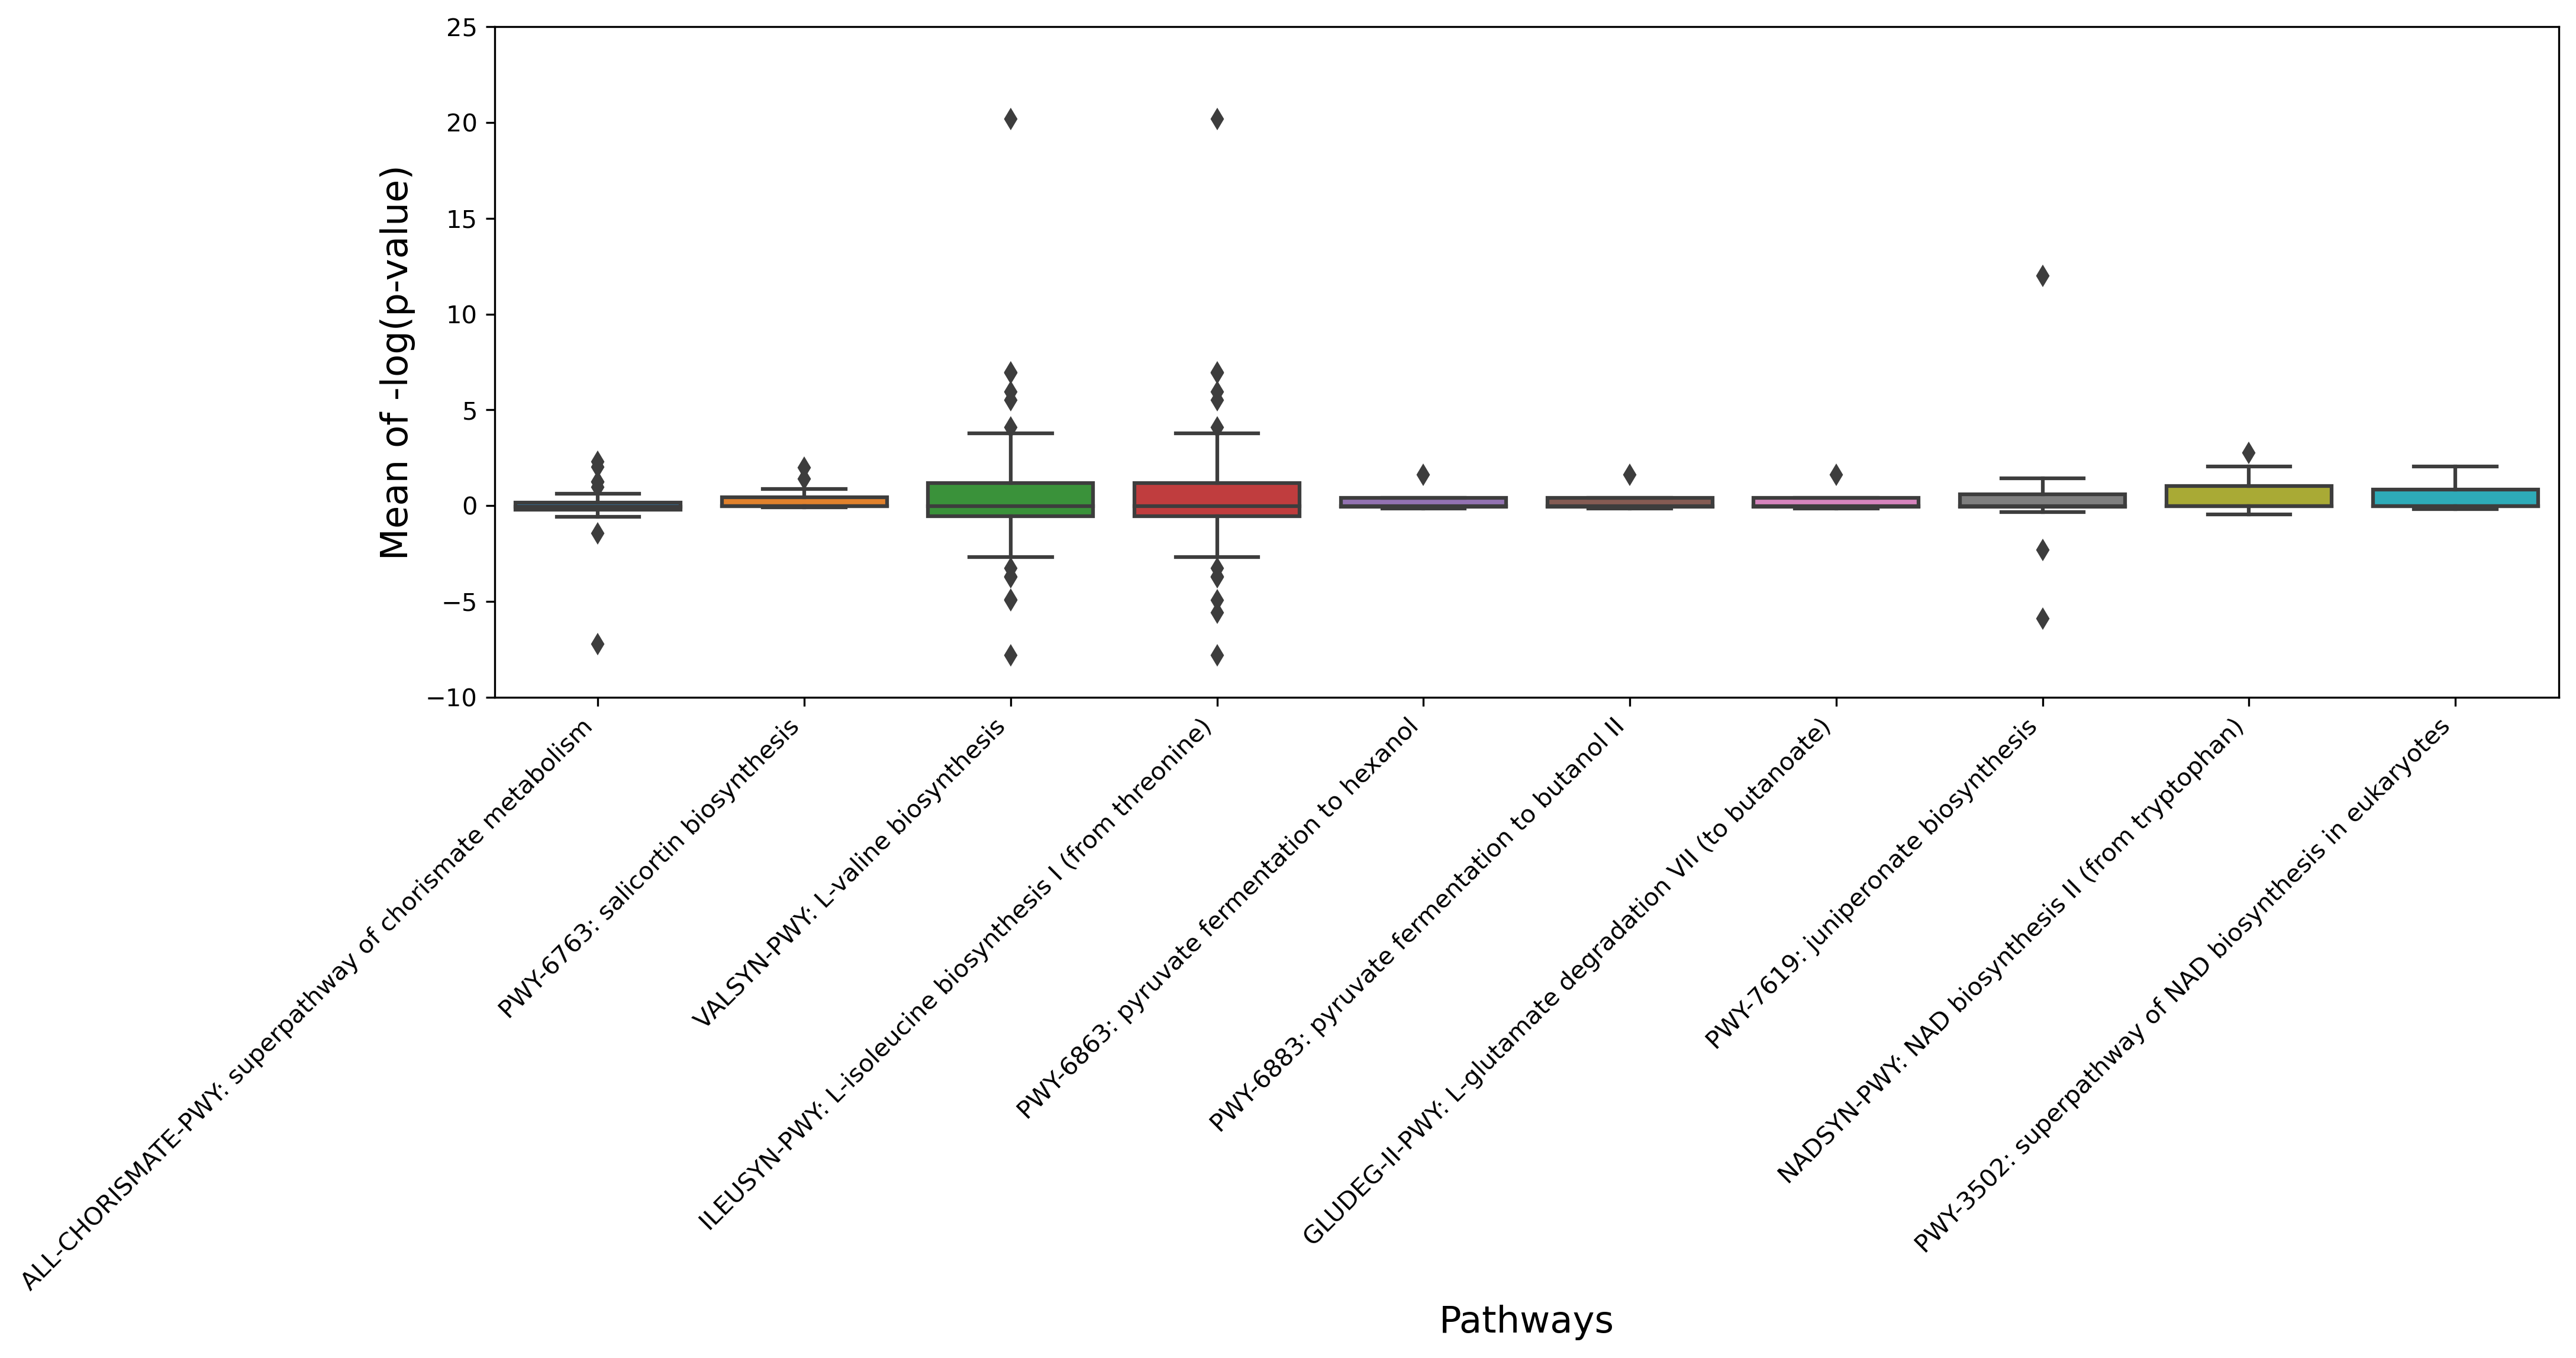

In [17]:
medians = result.groupby('Class').median().sort_values(['Delta_logp'], ascending=True)
order = medians.index[:10]
_ = plt.figure(0, (15, 5), dpi=300)
_ = sns.boxplot(x="Class", y="Delta_logp", data=result, order=order)
_ = plt.xticks(rotation=45, ha='right')
#_ = plt.xticks([], [])
_ = plt.ylim(-10,25)
_ = plt.ylabel('Mean of -log(p-value)', fontsize=15)
_ = plt.xlabel('Pathways', fontsize=15)
#plt.savefig('../Results/4.PathwayDelta_logp_End10.pdf',bbox_inches = 'tight')
_ = plt.show()